PCA with Iris dataset
==================


<a href="https://colab.research.google.com/github/PGM-Lab/ProbModelingDNNs/blob/master/notebooks/iris-PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Principal Component Analysis (PCA) is a classic statistical technique for dimensionality reduction. It defines a mapping between the $d$-dimensional data-representation of a point $\boldsymbol{x}$ and its $k$-dimensional latent representation, $\boldsymbol{z}$. The latent representation is known as the scores, and the affine transformation is performed using the loading matrix $\boldsymbol{\beta}$, which has dimensions $k\times d$. 


In this notebook, this technique is applied to the well-known Iris dataset.

## Setting up the system

First, we will install and import the required packages as follows.

In [ ]:
!pip install tensorflow
!pip install tensorflow-probability
!pip install matplotlib
!pip install setuptools
!pip install pandas

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow_probability import edward2 as ed
import numpy as np
import matplotlib.pyplot as plt

tf.reset_default_graph()
tf.set_random_seed(1234)

k = 2
eps = tf.constant(0.0000001)

learning_rate=0.01
num_epochs = 5000
verbose=True


## Data 

The iris dataset is provided as a csv file which is located in this repository. Thus, the data is loadad as follows.

In [3]:
# load the data
df = pd.read_csv("../data/iris.csv")
x_train = df.values[:,0:4].astype(np.float32)
y_train = df.values[:,4]

# model constants
N, d = np.shape(x_train)

## Model definition

The implementation for the generative model for a PCA model (Algorithm 1) is defined below. The input parameters are: `k` is the latent dimension, `d` is the data-dimension and `N`the number of samples or data instances. 

In [4]:
def pca(k, d, N):
    # Define local latent variables
    z = ed.Normal(loc=tf.zeros([k]), scale=1., sample_shape=N, name="z")

    # Define the weights
    beta = ed.Normal(loc=tf.zeros([k, d]), scale=1., name="beta")
    alpha = ed.Normal(loc=tf.zeros([N, d]), scale=1., name="alpha")

    # Define local random variables
    x = ed.Normal(loc=z @ beta + alpha, scale=1., name="x")  # N,k  @ k,d  +  N,d

    return z, (beta, alpha), x



This is a latent variable model (LVM) where the latent representation $\boldsymbol{z}$ is known as the scores, and the affine transformation is performed using the loading matrix  $\boldsymbol{\beta}$.


## Inference

Variational inference is a deterministic technique that finds a tractable approximation to an intractable (posterior) distribution. 
We will use $q$ to denote the approximation, and use $p$ to signify the true distribution (like $p(\boldsymbol{\beta},\boldsymbol{z}|\boldsymbol{x})$ in the example above).
More specifically, ${\cal Q}$ will denote a set of possible approximations $q$.

In practice, we define a generative model for sampling from $q(\boldsymbol{\beta},\boldsymbol{z} | \boldsymbol{\lambda}, \boldsymbol{\phi})$, where $\boldsymbol{\lambda}, \boldsymbol{\phi}$ are the variational parameters to optimise.





In [5]:
def q_model(k, d, N):
    qz_loc = tf.Variable(tf.zeros([N, k]))
    qz_scale = tf.math.softplus(tf.Variable(tf.ones([N, k])))
    qz = ed.Normal(loc=qz_loc, scale=qz_scale, name="qz")

    qbeta_loc = tf.Variable(tf.zeros([k, d]))
    qbeta_scale = tf.math.softplus(tf.Variable(tf.ones([k, d])))
    qbeta = ed.Normal(loc=qbeta_loc, scale=qbeta_scale, name="qbeta")

    qalpha_loc = tf.Variable(tf.zeros([N, d]))
    qalpha_scale = tf.math.softplus(tf.Variable(tf.ones([N, d])))
    qalpha = ed.Normal(loc=qalpha_loc, scale=qalpha_scale, name="qalpha")

    return qz, (qbeta, qalpha)


qz, (qbeta, qalpha) = q_model(k, d, N)

Variational methods adjusts the parameters by maximizing the ELBO (Evidence LOwer Bound) denoted $\cal{L}$ and expressed as 

$\cal{L}(\boldsymbol{\lambda},\boldsymbol{\phi})  = \mathbb{E}_q [\ln p(\boldsymbol{x}, \boldsymbol{z}, \boldsymbol{\beta})] - \mathbb{E}_q [\ln q(\boldsymbol{\beta},\boldsymbol{z}|\boldsymbol{\lambda},\boldsymbol{\phi})]$

In Edward, this is done as follows.

In [6]:
def set_values(**model_kwargs):
    def interceptor(f, *args, **kwargs):
        name = kwargs.get("name")
        if name in model_kwargs:
            kwargs["value"] = model_kwargs[name]
        else:
            print(f"set_values not interested in {name}.")
        return ed.interceptable(f)(*args, **kwargs)
    return interceptor


with ed.interception(set_values(beta=qbeta, alpha=qalpha, z=qz, x=x_train)):
    pz, (pbeta, palpha), px = pca(k, d, N)

energy = tf.reduce_sum(pbeta.distribution.log_prob(pbeta.value)) + \
         tf.reduce_sum(palpha.distribution.log_prob(palpha.value)) + \
         tf.reduce_sum(pz.distribution.log_prob(pz.value)) + \
         tf.reduce_sum(px.distribution.log_prob(px.value))

entropy = tf.reduce_sum(qbeta.distribution.log_prob(qbeta.value)) + \
          tf.reduce_sum(qalpha.distribution.log_prob(qalpha.value)) + \
          tf.reduce_sum(qz.distribution.log_prob(qz.value))

elbo = energy - entropy



Finally, the ELBO function is maximized.

In [7]:
with tf.Session() as sess:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    t = []
    train = optimizer.minimize(-elbo)
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(num_epochs + 1):
        t.append(sess.run(elbo))
        sess.run(train)
        if verbose:
            if i % 10 == 0: print(".", end="", flush=True)

            if i % 50 == 0:
                str_elbo = str(t[-1] / 1000) + " k"
                print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)
                post = {"z": sess.run(qz.distribution.loc),
                        "beta": sess.run(qbeta.distribution.loc),
                        "alpha": sess.run(qalpha.distribution.loc)}

.
0 epochs	-6.645453125 k.....
50 epochs	-5.8677060546875 k.....
100 epochs	-5.68826318359375 k.....
150 epochs	-4.82096142578125 k.....
200 epochs	-4.54353515625 k.....
250 epochs	-3.86071923828125 k.....
300 epochs	-3.365240234375 k.....
350 epochs	-3.4430146484375 k.....
400 epochs	-2.87777197265625 k.....
450 epochs	-2.5546396484375 k.....
500 epochs	-2.333752197265625 k.....
550 epochs	-2.112590576171875 k.....
600 epochs	-1.969683837890625 k.....
650 epochs	-1.82658984375 k.....
700 epochs	-1.702961181640625 k.....
750 epochs	-1.659767822265625 k.....
800 epochs	-1.61607421875 k.....
850 epochs	-1.4909600830078125 k.....
900 epochs	-1.479588134765625 k.....
950 epochs	-1.411820556640625 k.....
1000 epochs	-1.38792041015625 k.....
1050 epochs	-1.35455517578125 k.....
1100 epochs	-1.3337449951171876 k.....
1150 epochs	-1.3648345947265625 k.....
1200 epochs	-1.3596009521484376 k.....
1250 epochs	-1.30536962890625 k.....
1300 epochs	-1.3338839111328125 k.....
1350 epochs	-1.331241333

After the inference, we can plot the hidden representation:

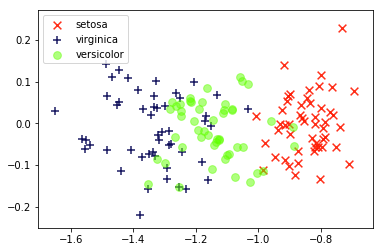

In [8]:
CLASSES = list(set(y_train))

markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(CLASSES)):
    col = colors[c]
    plt.scatter(post["z"][y_train == CLASSES[c], 0], post["z"][y_train == CLASSES[c], 1], color=col,
                label=CLASSES[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend()
plt.show()


fig.savefig("../img/pca_iris.pdf")